# VisualBacter

```
Detección de ETA's mediante vision computacional en redes nueronales convolucionales

Escrito por:

Juan Diego y George Giosue

```

# Imports

In [1]:
import csv
import sys
import tensorflow as tf
import cv2
import numpy as np
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import string
from keras import Model
from keras.models import Sequential
from keras.layers import Layer
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Input, BatchNormalization, Permute, LSTM, Reshape, Concatenate, Lambda, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from os import scandir
from time import time


# Local modules

sys.path.insert(0, os.path.join(Path(os.getcwd()).parent.parent, 'modules'))

import lib.utils as fns

tf.__version__


'2.16.1'

# GPU

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices(), "Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16766896940326741351
xla_global_id: -1
] Num GPUs Available:  0


In [3]:

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


# Routes and File extensions


In [24]:
TRAIN_DATA_PATH = "./data/train/"

TRAIN_CLASSES = {
  "filename" : "_classes.csv",
  "fields" : [],
  "rows" : []
}

train_data = []

with open(TRAIN_DATA_PATH+"/"+TRAIN_CLASSES['filename'], 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)
  
    # extracting field names through first row
    TRAIN_CLASSES['fields'] = next(csvreader)
  
    # extracting each data row one by one
    for row in csvreader:
        TRAIN_CLASSES['rows'].append(row)

def compose_images_with_class(payload, image_name):
  target_row = []
  
  for row in TRAIN_CLASSES["rows"]:
    if row[0] == image_name:
      target_row = row
      

  
  features = TRAIN_CLASSES["fields"][1::] # ['Bacteria A', 'Stafilomandarina' ]
  predictions = [int(p) for p in target_row[1::]] # [0, 0 , 1, 0]
  
  index_p = 0
  prediction = ''
  
  for index, p in enumerate(predictions):
    if p == 1:
      index_p = index
      
  prediction = features[index_p]      
  
  
  return {
    "image": payload,
    "image_name": image_name,
    "classname": prediction
  }
  
train_data = fns.imgs_to_array(TRAIN_DATA_PATH,'_classes.csv',cv2.IMREAD_COLOR, compose_images_with_class )
    
print(train_data[0])  

{'image': array([[[  0,   0,   0],
        [ 16,  16,  16],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[ 13,  13,  13],
        [195, 195, 195],
        [220, 220, 220],
        ...,
        [216, 216, 216],
        [216, 216, 216],
        [215, 215, 215]],

       [[  0,   0,   0],
        [227, 227, 227],
        [233, 233, 233],
        ...,
        [209, 209, 209],
        [209, 209, 209],
        [209, 209, 209]],

       ...,

       [[  0,   0,   0],
        [217, 217, 217],
        [213, 213, 213],
        ...,
        [209, 209, 209],
        [208, 208, 208],
        [207, 207, 207]],

       [[  0,   0,   0],
        [217, 217, 217],
        [214, 214, 214],
        ...,
        [208, 208, 208],
        [207, 207, 207],
        [206, 206, 206]],

       [[  1,   1,   1],
        [217, 217, 217],
        [214, 214, 214],
        ...,
        [207, 207, 207],
        [206, 206, 206],
        [206, 

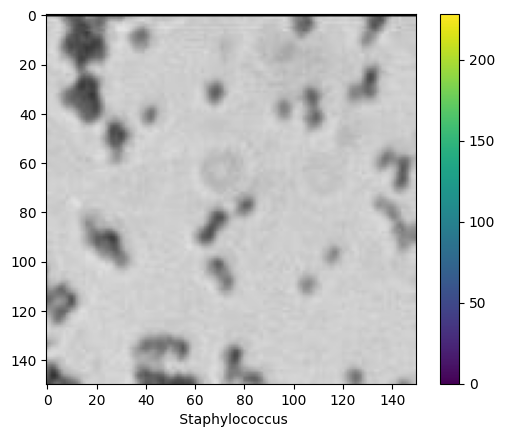

In [26]:
preview_index = 100

plt.figure()
plt.imshow(train_data[preview_index]['image'])
plt.colorbar()
plt.xlabel(train_data[preview_index]['classname'])
plt.grid(False)
plt.show()

# Hyperparameters


In [ ]:
# Downsample factor  [float]
PERCENTAGE_REDUCE = 0.15

# Scale factor of expansible data [int]

IMG_SHAPE = (128, 128)

EXTENSIBLE = {
    'value': True,
    'q_images': 50, # 250
}

# Model

MODEL_PARAMETERS = {
    'losses': tf.keras.losses.SparseCategoricalCrossentropy(),
    'optimizer': 'adam',
    'metrics': ['accuracy'],
    'fit': {
        'batches': {
            'train': 0.7,
            'test': 0.3,
        },
        'epochs': 10
    }
}


# Data Set and Extensible factor


In [ ]:
from functools import reduce

DATA_SET = fns.join_paths_from_extensions(DATA_PATH, std_ext, [])

q_images = fns.q_recursive_files(DATA_PATH, std_ext, 0)


DATA_SET_EXTENSIBLE = EXTENSIBLE['q_images'] * \
    q_images if EXTENSIBLE['value'] else q_images


## Overview


In [ ]:
print(f"""
                            SUMMARY

    - Percentage of reduction: {PERCENTAGE_REDUCE*100} % Quality

    - Scale factor of expansible data [{EXTENSIBLE['value']}]:
        factor: {EXTENSIBLE['q_images']}


        - N° of samples:

            - Images:
                {q_images} => {DATA_SET_EXTENSIBLE}

    - Batches weight:
        Train: {MODEL_PARAMETERS['fit']['batches']['train']}
        Test: {MODEL_PARAMETERS['fit']['batches']['test']}
""")


# Data processing


In [ ]:
# Placeholders

data = []
labels = []

# Feature Columns

class_names = [
    (index, key) for index, key in enumerate(ROUTES.keys())
]


## Unaltered

In [ ]:
""" for dse in DATA_SET:
    class_name = dse.split('\\')[-2]
    data.extend(fns.imgs_to_array(
        src=dse,
        callback=lambda source: labels.append(class_name),
        check_file=fns.pass_file,
        extensions=std_ext
    ))
 """

## Reduce Image

In [ ]:
if len(data) > 0:
    data.clear()
    labels.clear()

for dse in DATA_SET:
    class_name = dse.split('\\')[-2]
    for img_reduce in fns.reduce_flow(
        src=dse,
        ext=std_ext,
        dim=cv2.IMREAD_UNCHANGED,
        callback=lambda img: labels.append(
            fns.search_in_list(class_names, class_name)
        ),
        conf={
            'same_scale': False,
            'factor': {
                'size': IMG_SHAPE,
                'fx': 0.5,
                'fy': 0.7,
                'interpolation': cv2.INTER_AREA
            }
        }
    ):
        data.append(img_reduce)


## Expand Data

In [ ]:
# 1m estimation -> 200x images
# 4m estimation -> 600x images
# 2m estimation -> 400x images

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='nearest')

data = fns.extendible_flow(
    images=data,
    image_data_generator=datagen,
    u_quantity=EXTENSIBLE['q_images']
)

labels = [ np.repeat(label, EXTENSIBLE['q_images']) for label in labels ]

labels = fns.merge(labels)

data = np.array(data)

In [ ]:

assert len(data) == len(labels), 'The data does not match in size'

# Image Preview

In [ ]:
index = 16

fns.show_img(index, data, labels)


# Split Test and Train

In [ ]:
from sklearn.model_selection import train_test_split

(train_data, test_data, train_labels, test_labels) = train_test_split(
    data,
    labels,
    test_size=MODEL_PARAMETERS['fit']['batches']['test']
)


In [ ]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
train_data[0].shape

In [ ]:
print(f"""
    N° train data: {len(train_data)} type: {type(train_data)}
    N° train labels: {len(train_labels)} type: {type(train_labels)}

    N° test data: {len(test_data)} type: {type(test_data)}
    N° test labels: {len(test_labels)} type: {type(test_labels)}
""")


## Architecture


In [ ]:


INPUT_SHAPE = IMG_SHAPE + (3,)

activation = 'relu'
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = activation, padding = 'same', input_shape = INPUT_SHAPE))
model.add(BatchNormalization())

model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dense(len(class_names), activation = 'softmax'))


## Sumary


In [ ]:
from tensorflow import keras

model.summary()
keras.utils.plot_model(model, 'model_arch.png', show_shapes=True)

# Compile and Train Model


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=MODEL_PARAMETERS['metrics'],
              run_eagerly=True)

In [ ]:
history = model.fit(train_data, train_labels, epochs=300, 
                    validation_data=(test_data, test_labels), batch_size=32)

In [ ]:
test_loss, test_acc = model.evaluate(test_data,  test_labels, verbose=2)
print(test_acc)

# Performance

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
testimagename = 'diego_h'

testimage = cv2.imread(fr'C:\Users\brhiann\Desktop\repos\passnet\test\{testimagename}.jpg', cv2.IMREAD_UNCHANGED)
# 128 x 128

testimage = cv2.resize(testimage, IMG_SHAPE)

testimage = cv2.cvtColor(testimage, cv2.COLOR_BGR2RGB)

plt.imshow(testimage)
plt.show()

# Prediccion

In [ ]:
# predict

testimagse = np.array([testimage])

predictions = model.predict(testimagse)

index_max = np.argmax(predictions[0])
index_min = np.argmin(predictions[0])

print(f"""

    

    The prediction is [MAX ARG]: {class_names[index_max
    ][1]}
""")


In [ ]:
predictions[0]

In [ ]:

MODELS_PATH = os.path.join(Path(os.getcwd()).parent.parent, 'models')

MODEL_EXTENSION = "h5"

MODEL_NAME = f"model_{DATA_SET_EXTENSIBLE}_{IMG_SHAPE[0]}x_3_{str(round(test_acc, 4)*10000).split('.')[0]}_mc"

MODEL_FULL_NAME = f"{MODEL_NAME}.{MODEL_EXTENSION}"


model.save(os.path.join(MODELS_PATH, MODEL_FULL_NAME))

# TF Lite

In [ ]:
model_loaded =tf.keras.models.load_model(os.path.join(MODELS_PATH, MODEL_NAME + '.' + MODEL_EXTENSION))


#Convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)

tflite_model = converter.convert()

#Save the model.

with open(f'{os.path.join(MODELS_PATH, MODEL_NAME)}.tflite', 'wb') as f:
    f.write(tflite_model)